# Clasificación de textos cortos en emociones

## Contexto:
El análisis de sentimientos es un área que genera valor en múltiples industrias. Usualmente se utilizan técnicas de NLP para clasificar rápidamente textos en un sentimiento positivo, negativo o neutral. Sin embargo, esta clasificación es bastante limitada y no permite un entendimiento profundo. Por esto, se requiere clasificar textos cortos en un espectro de emociones.

Para este caso se abordan las emociones desde un punto de vista clásico en el cual se clasifican en 7 emociones principales: 
1) `shame` = vergüenza
2) `sadness` = tristeza
3) `joy` = alegría
4) `guilt` = culpa
5) `fear` = miedo
6) `disgust` = asco
7) `anger` = ira

Se utiliza el conjunto de datos **ISEAR**, que consiste de 7666 encuestas realizadas por múltiples psicológos en los años 90 en varios países. La encuesta consistía en presentarle una emoción al entrevistado y este debía responder una situación que representara dicha emoción. Este dataset fue elegido porque ha sido ampliamente utilizado para entrenar y comparar el rendimiento de modelos en la detección de emociones.

## Objetivo:
El objetivo de este Notebook es evaluar el rendimiento de diferentes modelos para la clasificación del texto en emociones.

## Procedimiento:
Se van a evaluar el rendimiento de modelos correspondientes a diferentes técnicas: técnicas de **machine learning**, técnicas de **redes neuronales** y **transformers**

# Modelos de Machine Learning

## 0. Libraries and input data

In [27]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim.downloader as api
from gensim.models import Word2Vec, FastText
from sklearn.tree import DecisionTreeClassifier
import warnings
from tqdm import tqdm
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

## Técnicas de Machine Learning

Se van a utilizar los modelos de `support vector machine`, `decision tree classifier` y `random forests classifier` para realizar un proceso de clasificación multiclase. Adicionalmente, se van a comparar los resultados con un modelo dummy como línea base.

## 1. Split dataset into train, test and validation

Se cargan los conjuntos de datos previamente separados en train, validation y test de manera aleatoria y balanceada

In [4]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv")
df_val = pd.read_csv("../data/data_to_model/val_data.csv")
df_test = pd.read_csv("../data/data_to_model/test_data.csv")

In [5]:
print(df_test.shape[0])
df_test.head()

754


,text,emotion
0,when a friend carelessly broke and object in m...,anger
1,when i felt powerless to help the poor or when...,sadness
2,one of my best friends'fianct broke off the re...,shame
3,i hadn't been at my parent's place for a long ...,sadness
4,when i didn't notify someone that he was summo...,guilt


In [6]:
print(df_val.shape[0])
df_val.head()

753


,text,emotion
0,when caught shop-lifting as for shame,guilt
1,i realised that someone was insidiously attemp...,disgust
2,the carterer refused to give me sugar to add t...,disgust
3,i was severely reprimanded for a trivial offen...,shame
4,i found myself a place after looking for one f...,joy


In [18]:
print(df_train.shape[0])
df_train.head()

6027


,text,emotion
0,when the week for exams came i got afraid as t...,fear
1,i was sleeping when i heard the neighbours scr...,fear
2,there was a time when my room looked terribly ...,shame
3,when my friend told me that he would come and ...,joy
4,"when i saw the film ""johnny got his gun"" which...",sadness


## 2. Pre-Process the text data.

### 2.1. Function to Pre-process the text data


Antes de enviar los textos a los modelos de Machine Learning se debe realizar algunas transformaciones. Se pruebas dos métodos para preprocesar la data:
El primero realizar transformaciones clásicas en NLP como remover stop-words, lemmantización y otros para evitar que los modelos aprendan de palabras que son muy comunes y que no agregan valor a la predicción.
La segunda solo tokeniza el texto y remueve stop words.

In [19]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    return " ".join(tokens)

### 2.2. Functions to vectorize the text

Los textos se deben convertir en representaciones númericas para que puedan ser interpretados por los modelos. Se va a probar la eficiencia de los modelos con diferentes métodos de vectorización como `tfidf`, `word2vec`, `GloVe` y `FastText`.

In [7]:
# TF-IDF Vectorizer
def tfidf_vec(max_features=500):
    tfidf = TfidfVectorizer(max_features=max_features)
    return tfidf

In [8]:
# Word2Vec Vectorizer for preprocessed text
def word2vec_vec_preprocessed(corpus, vector_size=100, window=5, min_count=1, sg=0):
    """
    Applies Word2Vec to a corpus of preprocessed text and returns document embeddings.

    Parameters:
    - corpus: List of preprocessed text documents (strings).
    - vector_size: Dimensionality of the word vectors.
    - window: Maximum distance between the current and predicted word within a sentence.
    - min_count: Ignores all words with total frequency lower than this.
    - sg: Training algorithm: 1 for skip-gram; 0 for CBOW.

    Returns:
    - List of document vectors as the average Word2Vec vectors.
    """

    # Step 1: Split each preprocessed text row into words (assuming it's space-separated after preprocessing)
    tokenized_corpus = [text.split() for text in corpus]

    # Step 2: Train Word2Vec model
    w2v_model = Word2Vec(
        sentences=tokenized_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
    )

    # Step 3: Compute average word vectors for each document
    def document_vector(doc):
        # Filter words that exist in the Word2Vec model's vocabulary
        words = [word for word in doc if word in w2v_model.wv.index_to_key]
        if len(words) == 0:
            return np.zeros(vector_size)  # Return zero vector if no valid words
        return np.mean(w2v_model.wv[words], axis=0)

    # Step 4: Apply document_vector to each document in the corpus
    doc_vectors = [document_vector(doc) for doc in tokenized_corpus]

    return np.array(doc_vectors)

In [9]:
# Function to load GloVe embeddings from a file
def load_glove_embeddings(file_path):
    """
    Loads GloVe embeddings from a file and returns a dictionary.

    Parameters:
    - file_path: The path to the GloVe file (e.g., 'glove.6B.100d.txt').

    Returns:
    - Dictionary of words and their corresponding GloVe embeddings.
    """
    embeddings_index = {}

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    return embeddings_index


# Function to vectorize a document using pre-trained GloVe embeddings
def glove_vec_preprocessed(corpus, glove_embeddings, vector_size=100):
    """
    Converts each document in the corpus to a vector using the GloVe embeddings.

    Parameters:
    - corpus: List of preprocessed text documents (strings).
    - glove_embeddings: Dictionary of GloVe embeddings.
    - vector_size: The size of the GloVe vectors (must match the embeddings' dimensionality).

    Returns:
    - List of document vectors as the average GloVe vectors.
    """

    glove_file_path = "../data/config/glove.6B.100d.txt"  # Replace with the actual path to the GloVe file
    glove_embeddings = load_glove_embeddings(glove_file_path)

    def document_vector(doc):
        # Split each preprocessed document into words
        words = doc.split()

        # Retrieve the GloVe vectors for the words that are present in the GloVe embeddings
        word_vectors = [
            glove_embeddings[word] for word in words if word in glove_embeddings
        ]

        if len(word_vectors) == 0:
            # Return zero vector if no words in the document are in the GloVe vocabulary
            return np.zeros(vector_size)

        # Return the average of the word vectors
        return np.mean(word_vectors, axis=0)

    # Apply the document_vector function to each document in the corpus
    doc_vectors = [document_vector(doc) for doc in corpus]

    return np.array(doc_vectors)

In [10]:
# FastText Vectorizer for preprocessed text
def fasttext_vec_preprocessed(corpus, vector_size=100, window=5, min_count=2, sg=0):
    """
    Applies FastText to a corpus of preprocessed text and returns document embeddings.

    Parameters:
    - corpus: List of preprocessed text documents (strings).
    - vector_size: Dimensionality of the word vectors.
    - window: Maximum distance between the current and predicted word within a sentence.
    - min_count: Ignores all words with total frequency lower than this.
    - sg: Training algorithm: 1 for skip-gram; 0 for CBOW.

    Returns:
    - List of document vectors as the average FastText vectors.
    """

    # Step 1: Split each preprocessed document into words (assuming it's space-separated after preprocessing)
    tokenized_corpus = [text.split() for text in corpus]

    # Step 2: Train FastText model
    fasttext_model = FastText(
        sentences=tokenized_corpus,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        sg=sg,
    )

    # Step 3: Compute average word vectors for each document
    def document_vector(doc):
        # Retrieve FastText vectors for the words (even OOV words will have vectors due to subword n-grams)
        word_vectors = [
            fasttext_model.wv[word] for word in doc if word in fasttext_model.wv
        ]

        if len(word_vectors) == 0:
            # Return zero vector if no words in the document are in the vocabulary
            return np.zeros(vector_size)

        # Return the average of the word vectors
        return np.mean(word_vectors, axis=0)

    # Step 4: Apply document_vector to each document in the corpus
    doc_vectors = [document_vector(doc) for doc in tokenized_corpus]

    return np.array(doc_vectors)

## 3.  Models

### Validation model method.

Se va a usar GridSearchCv para encontrar los mejores hiperparámetros de cada modelo. Dado que esta función utiliza CrossValidation, no necesitamos tener pre definido un conjunto de validación dado que el proceso se encarga de crear este subset de manera implicita.

Además, se van a encontrar los mejores modelos para diferentes formas de preparar el texto:
1. Usando TfIdf Vecotrizer
2. Usando Word2Vec Vecotrizer
3. Usando GloVe Vecotrizer
4. Usando FastText Vecotrizer


In [11]:
df_train = pd.concat([df_train, df_val]).reset_index(drop=True)

X_train = df_train["text"]
y_train = df_train["emotion"]

X_test = df_test["text"]
y_test = df_test["emotion"]

### 3.0.0. Base Model

Inicialmente se prueba un modelo dummy de base.

In [24]:
# Assuming GloVe is already loaded using your function
glove_embeddings = load_glove_embeddings("../data/config/glove.6B.100d.txt")

# Define transformer functions for each vectorizer


def tfidf_transformer(corpus):
    tfidf = tfidf_vec(max_features=1500)
    return tfidf.fit_transform(corpus)


def word2vec_transformer(corpus):
    return word2vec_vec_preprocessed(corpus)


def glove_transformer(corpus):
    return glove_vec_preprocessed(corpus, glove_embeddings)


def fasttext_transformer(corpus):
    return fasttext_vec_preprocessed(corpus)


# Define a function to select a vectorizer based on the method
def vectorize(corpus, method):
    if method == "tfidf":
        return tfidf_transformer(corpus)
    elif method == "word2vec":
        return word2vec_transformer(corpus)
    elif method == "glove":
        return glove_transformer(corpus)
    elif method == "fasttext":
        return fasttext_transformer(corpus)
    else:
        raise ValueError("Unknown vectorization method")


# Function to use in the pipeline for applying the selected vectorizer
def vectorizer_pipeline(corpus, vectorizer_method):
    return vectorize(corpus, method=vectorizer_method)

Starting Grid Search for DummyClassifier with tfidf vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for tfidf: {'classifier__strategy': 'uniform'}
Best F1 score for tfidf (from Grid Search): 0.14056047197640117

Classification Report for tfidf DummyClassifier:
              precision    recall  f1-score   support

       anger       0.14      0.15      0.14       109
     disgust       0.13      0.12      0.12       107
        fear       0.15      0.14      0.14       109
       guilt       0.09      0.10      0.10       106
         joy       0.10      0.09      0.09       109
     sadness       0.16      0.15      0.15       108
       shame       0.13      0.13      0.13       106

    accuracy                           0.13       754
   macro avg       0.13      0.13      0.13       754
weighted avg       0.13      0.13      0.13       754



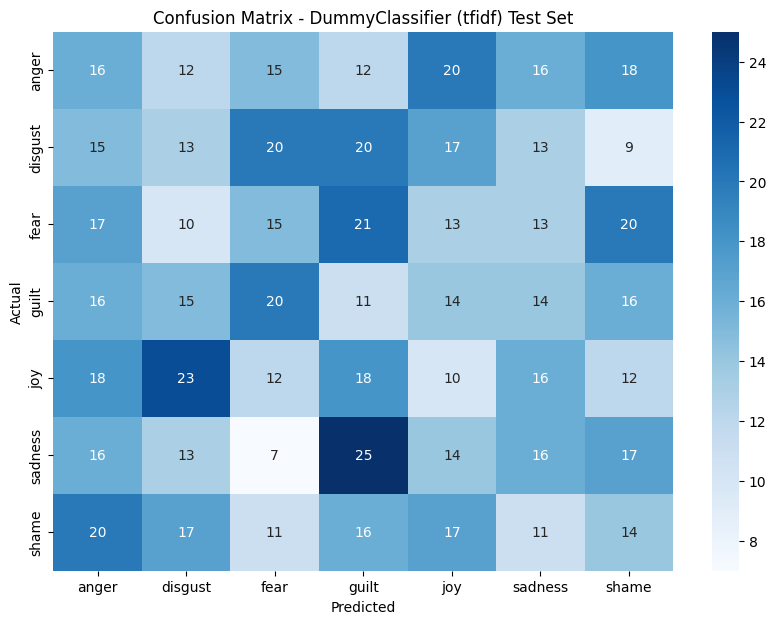

Starting Grid Search for DummyClassifier with word2vec vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for word2vec: {'classifier__strategy': 'uniform'}
Best F1 score for word2vec (from Grid Search): 0.14056047197640117

Classification Report for word2vec DummyClassifier:
              precision    recall  f1-score   support

       anger       0.14      0.15      0.14       109
     disgust       0.13      0.12      0.12       107
        fear       0.15      0.14      0.14       109
       guilt       0.09      0.10      0.10       106
         joy       0.10      0.09      0.09       109
     sadness       0.16      0.15      0.15       108
       shame       0.13      0.13      0.13       106

    accuracy                           0.13       754
   macro avg       0.13      0.13      0.13       754
weighted avg       0.13      0.13      0.13       754



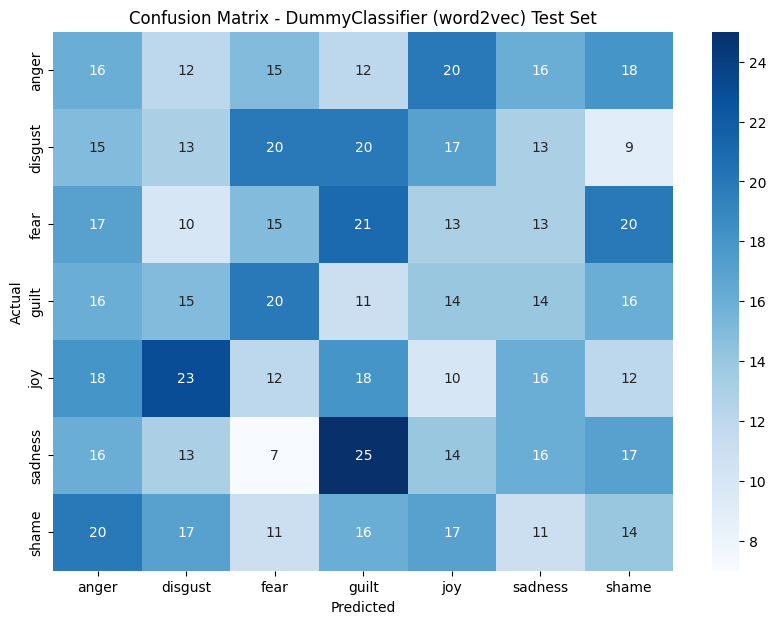

Starting Grid Search for DummyClassifier with glove vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for glove: {'classifier__strategy': 'uniform'}
Best F1 score for glove (from Grid Search): 0.14056047197640117

Classification Report for glove DummyClassifier:
              precision    recall  f1-score   support

       anger       0.14      0.15      0.14       109
     disgust       0.13      0.12      0.12       107
        fear       0.15      0.14      0.14       109
       guilt       0.09      0.10      0.10       106
         joy       0.10      0.09      0.09       109
     sadness       0.16      0.15      0.15       108
       shame       0.13      0.13      0.13       106

    accuracy                           0.13       754
   macro avg       0.13      0.13      0.13       754
weighted avg       0.13      0.13      0.13       754



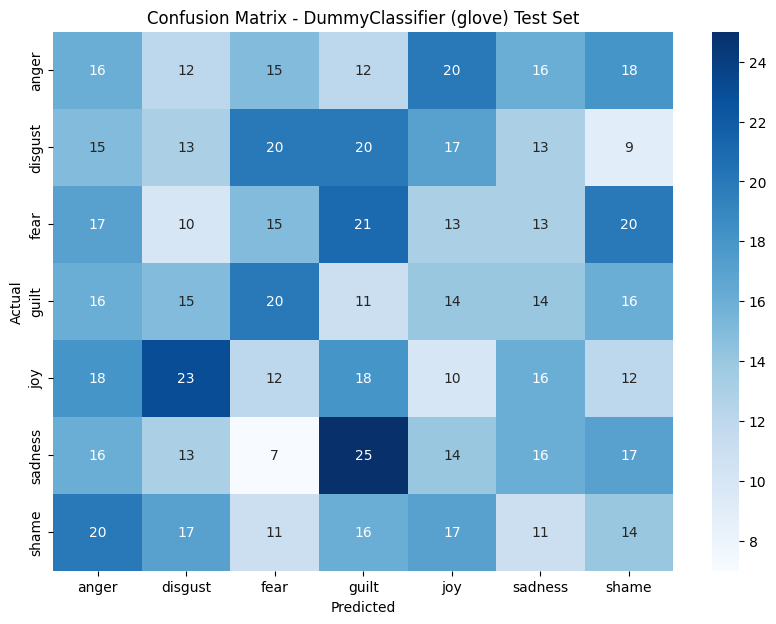

Starting Grid Search for DummyClassifier with fasttext vectorizer...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters for fasttext: {'classifier__strategy': 'uniform'}
Best F1 score for fasttext (from Grid Search): 0.14056047197640117

Classification Report for fasttext DummyClassifier:
              precision    recall  f1-score   support

       anger       0.14      0.15      0.14       109
     disgust       0.13      0.12      0.12       107
        fear       0.15      0.14      0.14       109
       guilt       0.09      0.10      0.10       106
         joy       0.10      0.09      0.09       109
     sadness       0.16      0.15      0.15       108
       shame       0.13      0.13      0.13       106

    accuracy                           0.13       754
   macro avg       0.13      0.13      0.13       754
weighted avg       0.13      0.13      0.13       754



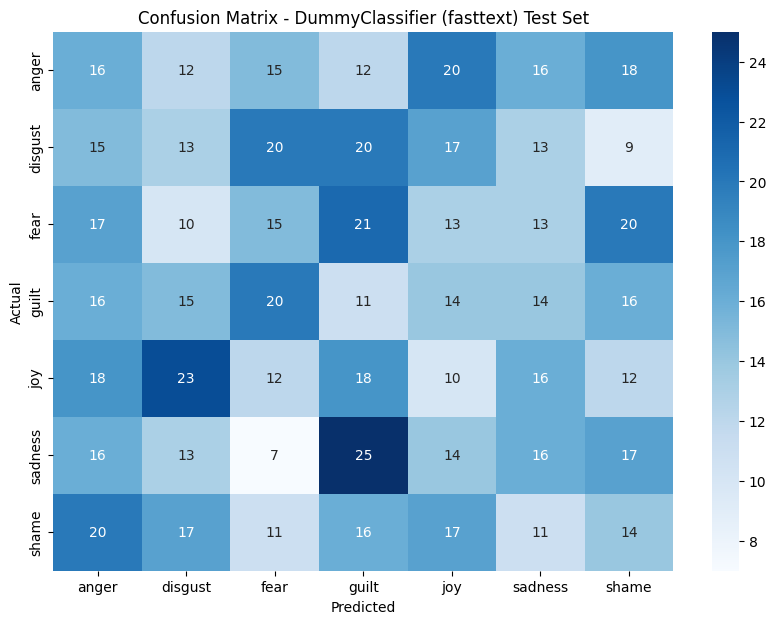

Best Results for Each Vectorizer with DummyClassifier:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,tfidf,0.14056,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
1,Dummy Classifier,word2vec,0.14056,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
2,Dummy Classifier,glove,0.14056,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
3,Dummy Classifier,fasttext,0.14056,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}


In [50]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search for DummyClassifier
for method in vectorizer_methods:
    print(f"Starting Grid Search for DummyClassifier with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", DummyClassifier(random_state=42)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV (for DummyClassifier strategies)
    param_grid = {
        "classifier__strategy": ["stratified", "uniform"],
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Print the classification report for the current vectorizer
    print(f"\nClassification Report for {method} DummyClassifier:")
    print(classification_report(y_test, y_test_pred))

    # Step 7: Generate and plot confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_test_df = pd.DataFrame(
        cm_test, index=grid_search.classes_, columns=grid_search.classes_
    )

    # Plot the confusion matrix for the test set
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test_df, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - DummyClassifier ({method}) Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Store the best results in the results list
    results.append(
        {
            "Model": "Dummy Classifier",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer with DummyClassifier:")
display(results_df)


### 3.0.1. Logistic Regresion Model

Starting Grid Search for Logistic Regression with tfidf vectorizer...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_rat

Best parameters for tfidf: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Best F1 score for tfidf (from Grid Search): 0.568731563421829

Classification Report for tfidf LogisticRegression:
              precision    recall  f1-score   support

       anger       0.12      0.08      0.10       109
     disgust       0.09      0.09      0.09       107
        fear       0.17      0.11      0.13       109
       guilt       0.20      0.32      0.24       106
         joy       0.17      0.29      0.21       109
     sadness       0.05      0.02      0.03       108
       shame       0.10      0.09      0.10       106

    accuracy                           0.14       754
   macro avg       0.13      0.14      0.13       754
weighted avg       0.13      0.14      0.13       754



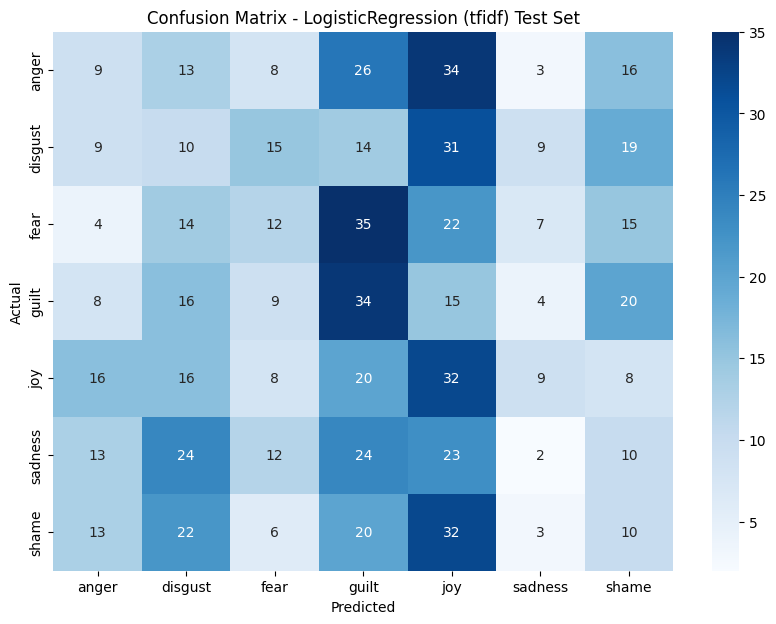

Starting Grid Search for Logistic Regression with word2vec vectorizer...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_rat

Best parameters for word2vec: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__l1_ratio': 5.526615652657683e-08, 'classifier__penalty': None, 'classifier__solver': 'newton-cg'}
Best F1 score for word2vec (from Grid Search): 0.3797935103244837

Classification Report for word2vec LogisticRegression:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.00      0.00      0.00       107
        fear       0.00      0.00      0.00       109
       guilt       0.00      0.00      0.00       106
         joy       0.00      0.00      0.00       109
     sadness       0.00      0.00      0.00       108
       shame       0.14      1.00      0.25       106

    accuracy                           0.14       754
   macro avg       0.02      0.14      0.04       754
weighted avg       0.02      0.14      0.03       754



/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

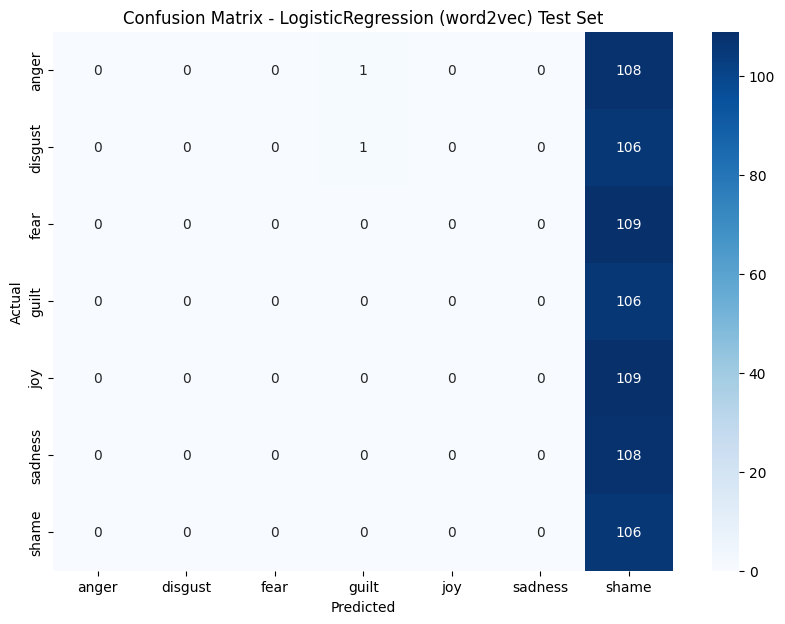

Starting Grid Search for Logistic Regression with glove vectorizer...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_rat

Best parameters for glove: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__l1_ratio': 0.5, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Best F1 score for glove (from Grid Search): 0.49306784660766956

Classification Report for glove LogisticRegression:
              precision    recall  f1-score   support

       anger       0.40      0.37      0.38       109
     disgust       0.47      0.45      0.46       107
        fear       0.60      0.60      0.60       109
       guilt       0.41      0.42      0.42       106
         joy       0.60      0.69      0.64       109
     sadness       0.50      0.48      0.49       108
       shame       0.39      0.39      0.39       106

    accuracy                           0.49       754
   macro avg       0.48      0.48      0.48       754
weighted avg       0.48      0.49      0.48       754



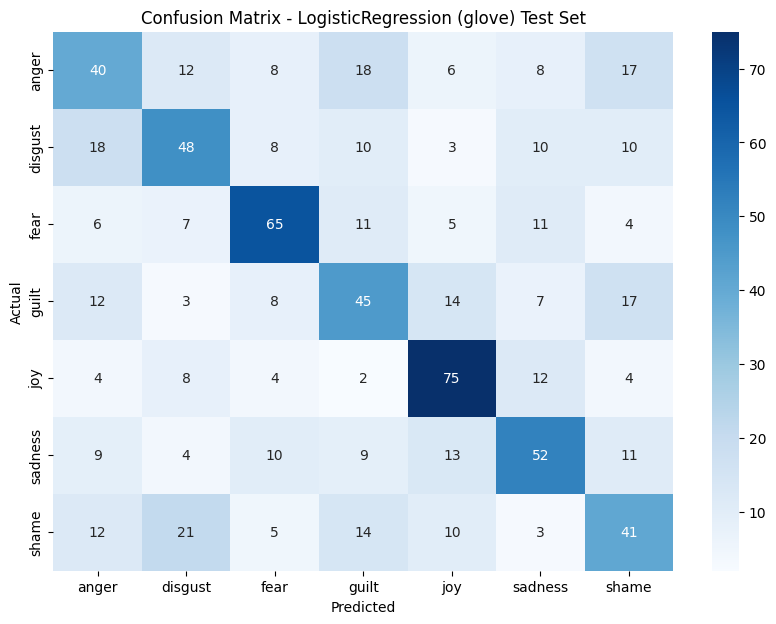

Starting Grid Search for Logistic Regression with fasttext vectorizer...
Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_rat

Best parameters for fasttext: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__l1_ratio': 5.526615652657683e-08, 'classifier__penalty': None, 'classifier__solver': 'newton-cg'}
Best F1 score for fasttext (from Grid Search): 0.37094395280235987

Classification Report for fasttext LogisticRegression:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.00      0.00      0.00       107
        fear       0.14      1.00      0.25       109
       guilt       0.00      0.00      0.00       106
         joy       0.00      0.00      0.00       109
     sadness       0.00      0.00      0.00       108
       shame       0.00      0.00      0.00       106

    accuracy                           0.14       754
   macro avg       0.02      0.14      0.04       754
weighted avg       0.02      0.14      0.04       754



/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

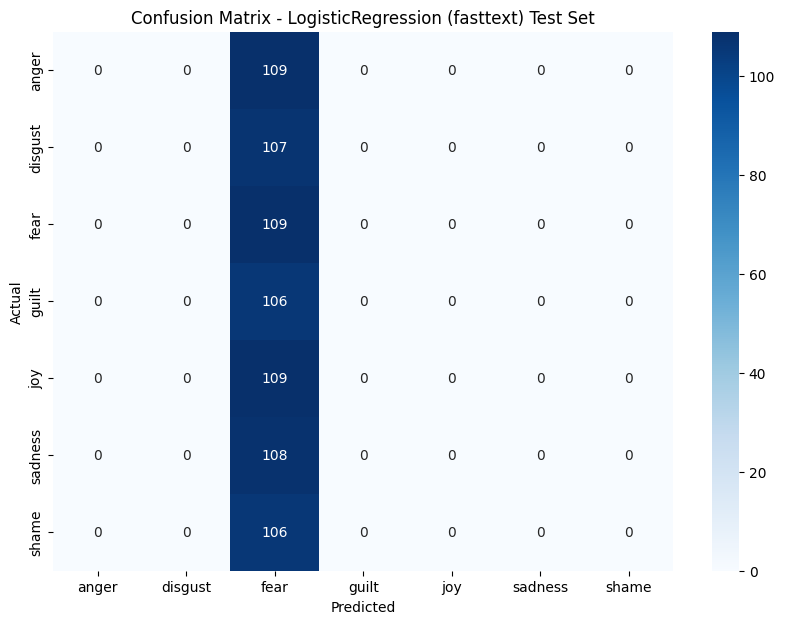

Best Results for Each Vectorizer:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,tfidf,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
1,Dummy Classifier,word2vec,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
2,Dummy Classifier,glove,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
3,Dummy Classifier,fasttext,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
0,Logistic Regression,tfidf,0.568732,0.144562,0.129332,0.144758,0.129676,"{'classifier__C': 1, 'classifier__class_weight..."
1,Logistic Regression,word2vec,0.379794,0.140584,0.020137,0.142857,0.035298,"{'classifier__C': 0.01, 'classifier__class_wei..."
2,Logistic Regression,glove,0.493068,0.485411,0.481583,0.484682,0.482492,"{'classifier__C': 1, 'classifier__class_weight..."
3,Logistic Regression,fasttext,0.370944,0.144562,0.020652,0.142857,0.036087,"{'classifier__C': 0.01, 'classifier__class_wei..."


In [51]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search
for method in vectorizer_methods:
    print(f"Starting Grid Search for Logistic Regression with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", LogisticRegression(max_iter=1000, random_state=42)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__C": [0.01, 0.1, 0.5, 1, 1.0892186949935163],
        "classifier__penalty": ["l1", "l2", "elasticnet", None],
        "classifier__class_weight": ["balanced", None],
        "classifier__l1_ratio": [5.526615652657683e-08, 0.5, 0.3],
        "classifier__solver": ["lbfgs", "newton-cg", "sag", "saga"],
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Print the classification report for the current vectorizer
    print(f"\nClassification Report for {method} LogisticRegression:")
    print(classification_report(y_test, y_test_pred))

    # Step 7: Generate and plot confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_test_df = pd.DataFrame(
        cm_test, index=grid_search.classes_, columns=grid_search.classes_
    )

    # Plot the confusion matrix for the test set
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test_df, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - LogisticRegression ({method}) Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Store the best results in the results list
    results.append(
        {
            "Model": "Logistic Regression",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df_logistic = pd.DataFrame(results)
results_df = pd.concat([results_df, results_df_logistic])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer:")
display(results_df)


### 3.0.2. Decision Tree Classifier

Starting Grid Search for Decision Tree with tfidf vectorizer...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for tfidf: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': 50, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Best F1 score for tfidf (from Grid Search): 0.43023598820058995

Classification Report for tfidf Decision Tree:
              precision    recall  f1-score   support

       anger       0.13      0.06      0.09       109
     disgust       0.05      0.01      0.02       107
        fear       0.16      0.06      0.08       109
       guilt       0.16      0.08      0.11       106
         joy       0.19      0.04      0.06       109
     sadness       0.00      0.00      0.00       108
       shame       0.15      0.77      0.25       106

    accuracy                           0.14       754
   macro avg       0.12      0.15      0.09       754
weighted avg       0.1

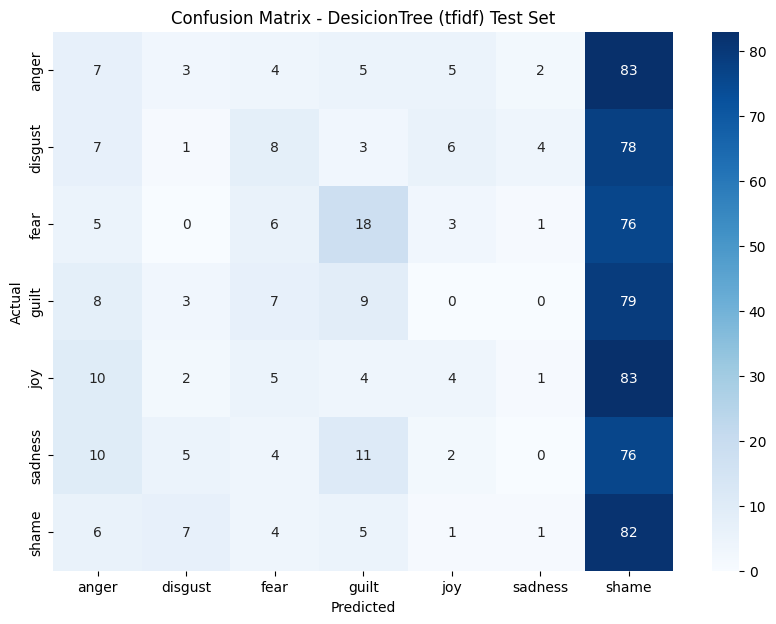

Starting Grid Search for Decision Tree with word2vec vectorizer...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for word2vec: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best F1 score for word2vec (from Grid Search): 0.23112094395280236

Classification Report for word2vec Decision Tree:
              precision    recall  f1-score   support

       anger       0.16      0.11      0.13       109
     disgust       0.00      0.00      0.00       107
        fear       0.00      0.00      0.00       109
       guilt       0.15      0.08      0.10       106
         joy       0.00      0.00      0.00       109
     sadness       0.15      0.85      0.25       108
       shame       0.00      0.00      0.00       106

    accuracy                           0.15       754
   macro avg       0.07      0.15      0.07       754
weigh

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

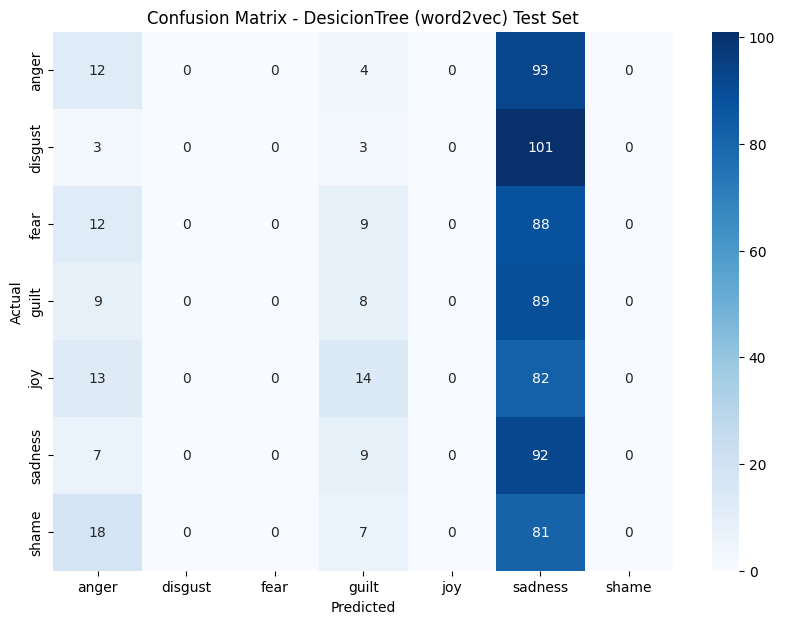

Starting Grid Search for Decision Tree with glove vectorizer...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for glove: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best F1 score for glove (from Grid Search): 0.27079646017699116

Classification Report for glove Decision Tree:
              precision    recall  f1-score   support

       anger       0.17      0.19      0.18       109
     disgust       0.26      0.23      0.24       107
        fear       0.44      0.33      0.38       109
       guilt       0.23      0.26      0.25       106
         joy       0.37      0.30      0.33       109
     sadness       0.39      0.27      0.32       108
       shame       0.23      0.35      0.28       106

    accuracy                           0.28       754
   macro avg       0.30      0.28      0.28       754
weighted avg     

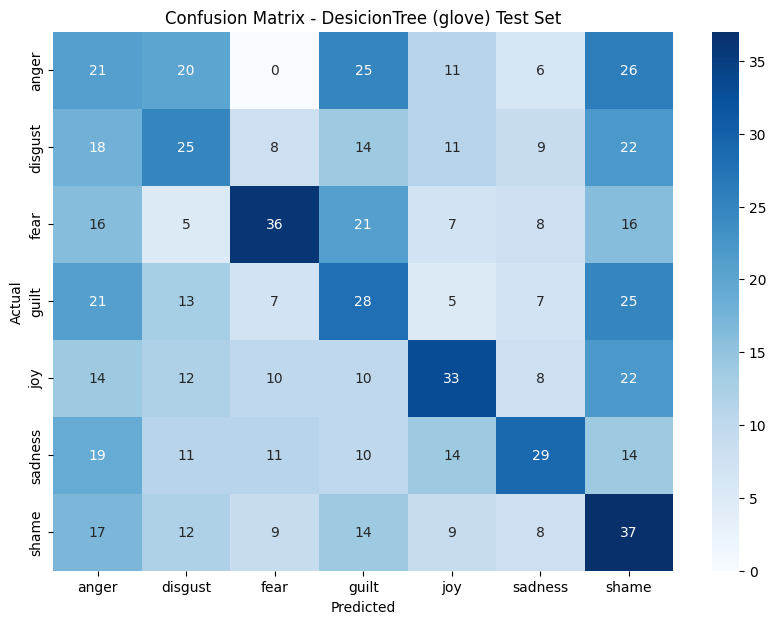

Starting Grid Search for Decision Tree with fasttext vectorizer...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters for fasttext: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Best F1 score for fasttext (from Grid Search): 0.21843657817109144

Classification Report for fasttext Decision Tree:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.40      0.02      0.04       107
        fear       0.00      0.00      0.00       109
       guilt       0.00      0.00      0.00       106
         joy       0.14      0.98      0.25       109
     sadness       0.00      0.00      0.00       108
       shame       0.00      0.00      0.00       106

    accuracy                           0.14       754
   macro avg       0.08      0.14      0.04       754
weigh

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

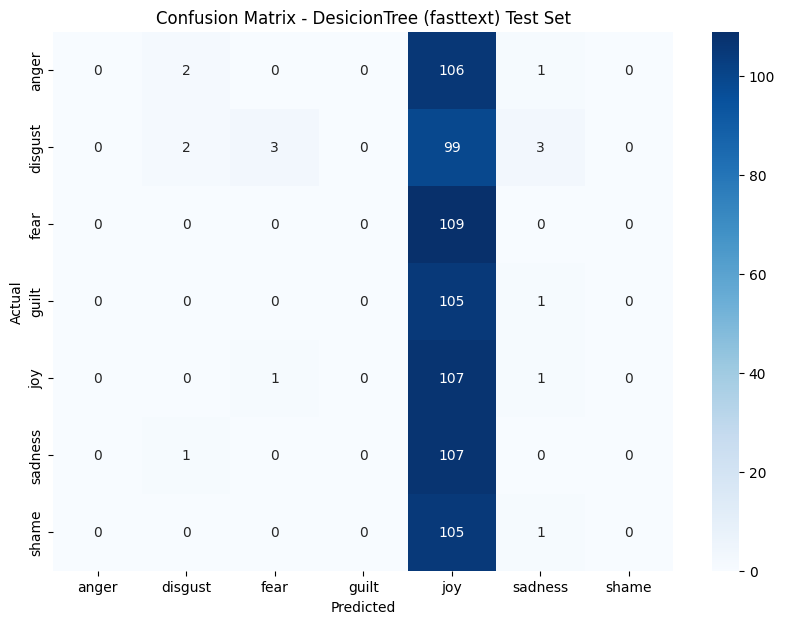

Best Results for Each Vectorizer with Decision Tree:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,tfidf,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
1,Dummy Classifier,word2vec,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
2,Dummy Classifier,glove,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
3,Dummy Classifier,fasttext,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
0,Logistic Regression,tfidf,0.568732,0.144562,0.129332,0.144758,0.129676,"{'classifier__C': 1, 'classifier__class_weight..."
1,Logistic Regression,word2vec,0.379794,0.140584,0.020137,0.142857,0.035298,"{'classifier__C': 0.01, 'classifier__class_wei..."
2,Logistic Regression,glove,0.493068,0.485411,0.481583,0.484682,0.482492,"{'classifier__C': 1, 'classifier__class_weight..."
3,Logistic Regression,fasttext,0.370944,0.144562,0.020652,0.142857,0.036087,"{'classifier__C': 0.01, 'classifier__class_wei..."
0,Decision Tree,tfidf,0.430236,0.144562,0.119846,0.146257,0.086340,"{'classifier__class_weight': None, 'classifier..."
1,Decision Tree,word2vec,0.231121,0.148541,0.065325,0.148202,0.068833,"{'classifier__class_weight': 'balanced', 'clas..."


In [52]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search for DecisionTreeClassifier
for method in vectorizer_methods:
    print(f"Starting Grid Search for Decision Tree with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", DecisionTreeClassifier(random_state=42)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__criterion": ["gini", "entropy", "log_loss"],  # Splitting criteria
        "classifier__max_depth": [
            None,
            10,
            20,
            30,
            50,
            100,
        ],  # Maximum depth of the tree
        "classifier__min_samples_split": [
            2,
            5,
            10,
        ],  # Minimum number of samples required to split
        "classifier__min_samples_leaf": [1, 2, 4],  # Minimum number of samples per leaf
        "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Print the classification report for the current vectorizer
    print(f"\nClassification Report for {method} Decision Tree:")
    print(classification_report(y_test, y_test_pred))

    # Step 7: Generate and plot confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_test_df = pd.DataFrame(
        cm_test, index=grid_search.classes_, columns=grid_search.classes_
    )

    # Plot the confusion matrix for the test set
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test_df, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - DesicionTree ({method}) Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Store the best results in the results list
    results.append(
        {
            "Model": "Decision Tree",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df_tree = pd.DataFrame(results)
results_df = pd.concat([results_df, results_df_tree])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer with Decision Tree:")
display(results_df)

### 3.0.2. Random Forests Classifier

Starting Grid Search for Random Forest with tfidf vectorizer...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best parameters for tfidf: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 50, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best F1 score for tfidf (from Grid Search): 0.5474926253687317

Classification Report for tfidf Random Forests:
              precision    recall  f1-score   support

       anger       0.22      0.13      0.16       109
     disgust       0.12      0.31      0.18       107
        fear       0.16      0.11      0.13       109
       guilt       0.19      0.18      0.18       106
         joy       0.14      0.14      0.14       109
     sadness       0.09      0.03      0.04       108
       shame       0.16      0.16      0.16       106

    accuracy                           0.15       754
   macro avg       0.15      0.15    

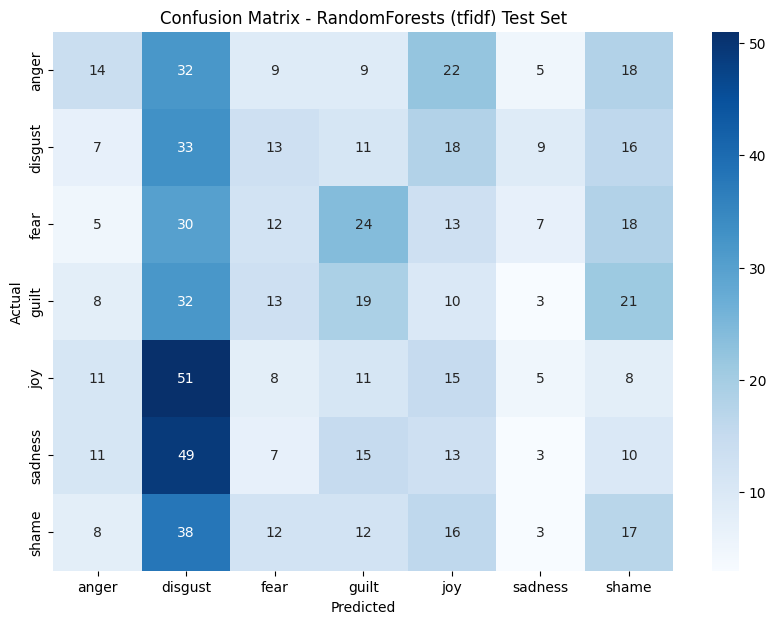

Starting Grid Search for Random Forest with word2vec vectorizer...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best parameters for word2vec: {'classifier__class_weight': None, 'classifier__criterion': 'log_loss', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 150}
Best F1 score for word2vec (from Grid Search): 0.2774336283185841

Classification Report for word2vec Random Forests:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.05      0.07      0.05       107
        fear       0.00      0.00      0.00       109
       guilt       0.00      0.00      0.00       106
         joy       0.16      0.40      0.23       109
     sadness       0.16      0.36      0.23       108
       shame       0.13      0.10      0.12       106

    accuracy                           0.13       754
   macro avg       0.07   

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

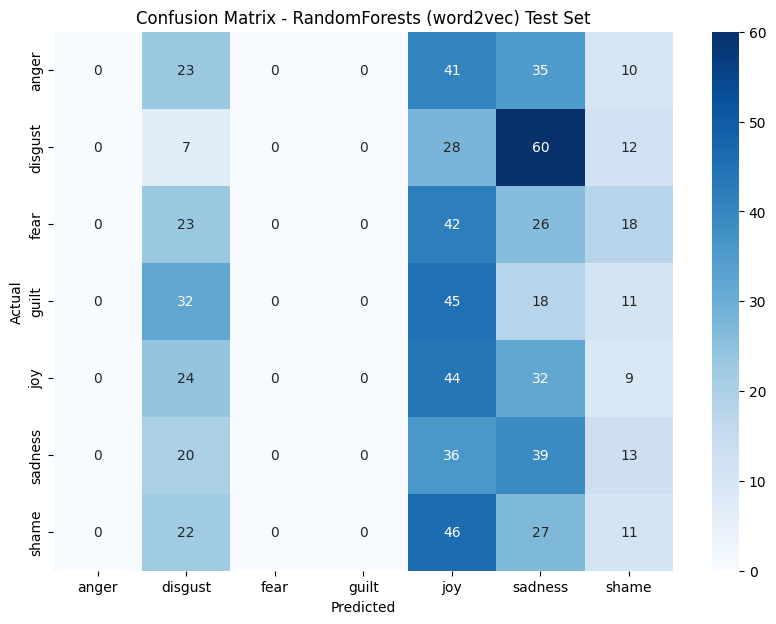

Starting Grid Search for Random Forest with glove vectorizer...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best parameters for glove: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best F1 score for glove (from Grid Search): 0.4243362831858407

Classification Report for glove Random Forests:
              precision    recall  f1-score   support

       anger       0.33      0.25      0.28       109
     disgust       0.47      0.46      0.46       107
        fear       0.58      0.57      0.58       109
       guilt       0.35      0.46      0.40       106
         joy       0.50      0.60      0.54       109
     sadness       0.44      0.39      0.41       108
       shame       0.40      0.36      0.38       106

    accuracy                           0.44       754
   macro avg       0.44      0.44  

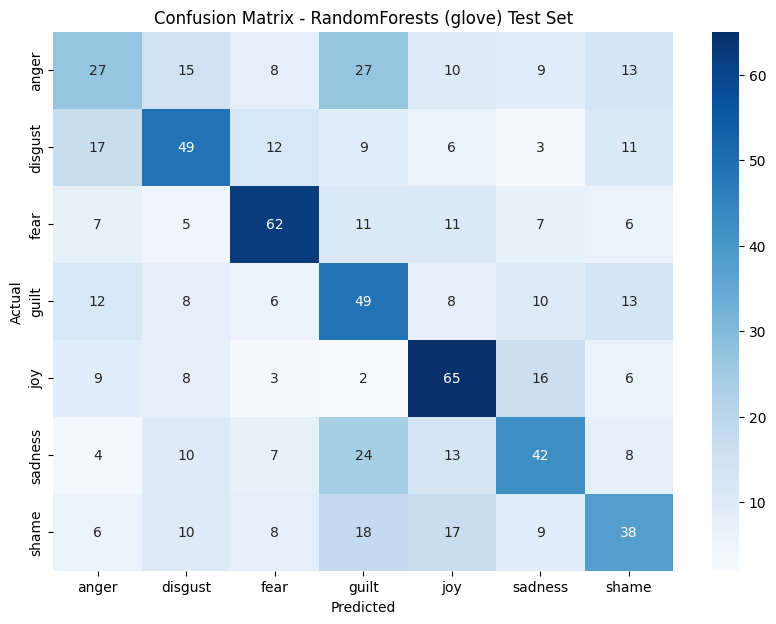

Starting Grid Search for Random Forest with fasttext vectorizer...
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best parameters for fasttext: {'classifier__class_weight': 'balanced', 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best F1 score for fasttext (from Grid Search): 0.25324483775811213

Classification Report for fasttext Random Forests:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.26      0.31      0.28       107
        fear       0.00      0.00      0.00       109
       guilt       0.00      0.00      0.00       106
         joy       0.00      0.00      0.00       109
     sadness       0.14      0.81      0.24       108
       shame       0.00      0.00      0.00       106

    accuracy                           0.16       754
   macro avg       0.06

/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

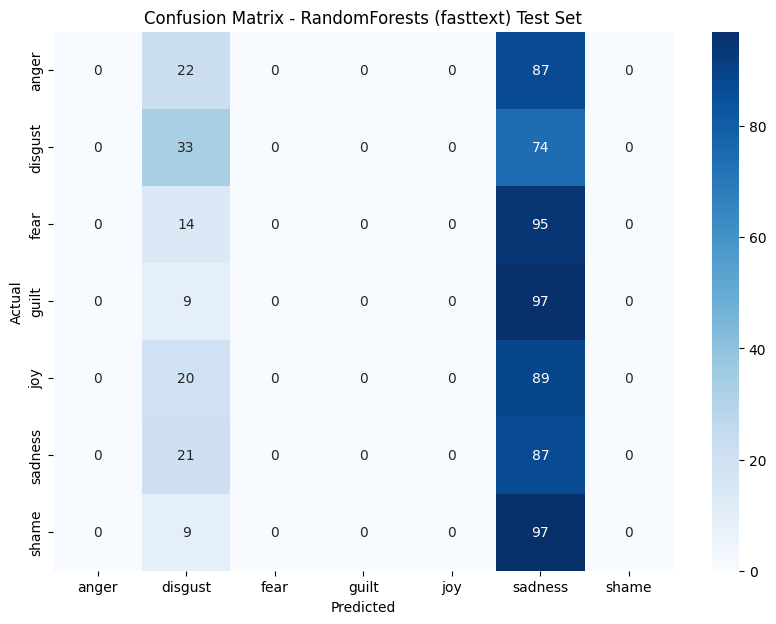

Best Results for Each Vectorizer with Random Forest:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,tfidf,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
1,Dummy Classifier,word2vec,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
2,Dummy Classifier,glove,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
3,Dummy Classifier,fasttext,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
0,Logistic Regression,tfidf,0.568732,0.144562,0.129332,0.144758,0.129676,"{'classifier__C': 1, 'classifier__class_weight..."
1,Logistic Regression,word2vec,0.379794,0.140584,0.020137,0.142857,0.035298,"{'classifier__C': 0.01, 'classifier__class_wei..."
2,Logistic Regression,glove,0.493068,0.485411,0.481583,0.484682,0.482492,"{'classifier__C': 1, 'classifier__class_weight..."
3,Logistic Regression,fasttext,0.370944,0.144562,0.020652,0.142857,0.036087,"{'classifier__C': 0.01, 'classifier__class_wei..."
0,Decision Tree,tfidf,0.430236,0.144562,0.119846,0.146257,0.086340,"{'classifier__class_weight': None, 'classifier..."
1,Decision Tree,word2vec,0.231121,0.148541,0.065325,0.148202,0.068833,"{'classifier__class_weight': 'balanced', 'clas..."


In [53]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search for RandomForestClassifier
for method in vectorizer_methods:
    print(f"Starting Grid Search for Random Forest with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", RandomForestClassifier(random_state=42)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__n_estimators": [
            50,
            100,
            150,
            200,
        ],  # Number of trees in the forest
        "classifier__criterion": ["gini", "log_loss", "entropy"],  # Splitting criteria
        "classifier__max_depth": [None, 10, 20, 30, 50],  # Maximum depth of the tree
        "classifier__min_samples_split": [
            2,
            5,
            10,
        ],  # Minimum number of samples required to split
        "classifier__min_samples_leaf": [
            1,
            2,
            4,
        ],  # Minimum number of samples required at a leaf node
        "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Print the classification report for the current vectorizer
    print(f"\nClassification Report for {method} Random Forests:")
    print(classification_report(y_test, y_test_pred))

    # Step 7: Generate and plot confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_test_df = pd.DataFrame(
        cm_test, index=grid_search.classes_, columns=grid_search.classes_
    )

    # Plot the confusion matrix for the test set
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test_df, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - RandomForests ({method}) Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Store the best results in the results list
    results.append(
        {
            "Model": "Random Forest",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df_rf = pd.DataFrame(results)
results_df = pd.concat([results_df, results_df_rf])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer with Random Forest:")
display(results_df)


### 3.0.3. Suport Vector Classifier (SVC)

Starting Grid Search for SVC with tfidf vectorizer...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for tfidf: {'classifier__C': 20, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best F1 score for tfidf (from Grid Search): 0.5595870206489676

Classification Report for tfidf SVC:
              precision    recall  f1-score   support

       anger       0.14      0.13      0.14       109
     disgust       0.12      0.10      0.11       107
        fear       0.19      0.08      0.11       109
       guilt       0.17      0.33      0.23       106
         joy       0.18      0.23      0.20       109
     sadness       0.03      0.01      0.01       108
       shame       0.10      0.12      0.11       106

    accuracy                           0.14       754
   macro avg       0.13      0.14      0.13       754
weighted avg       0.13      0.14      0.13       754



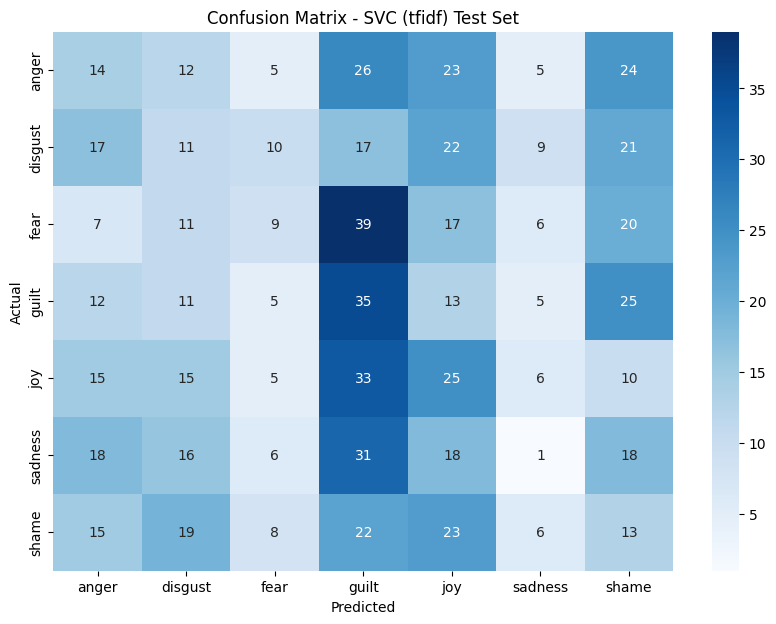

Starting Grid Search for SVC with word2vec vectorizer...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for word2vec: {'classifier__C': 30, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best F1 score for word2vec (from Grid Search): 0.3143067846607669

Classification Report for word2vec SVC:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.50      0.01      0.02       107
        fear       0.14      1.00      0.25       109
       guilt       0.00      0.00      0.00       106
         joy       0.00      0.00      0.00       109
     sadness       0.00      0.00      0.00       108
       shame       0.00      0.00      0.00       106

    accuracy                           0.15       754
   macro avg       0.09      0.14      0.04       754
weighted avg       0.09      0.15      0.04       754



/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

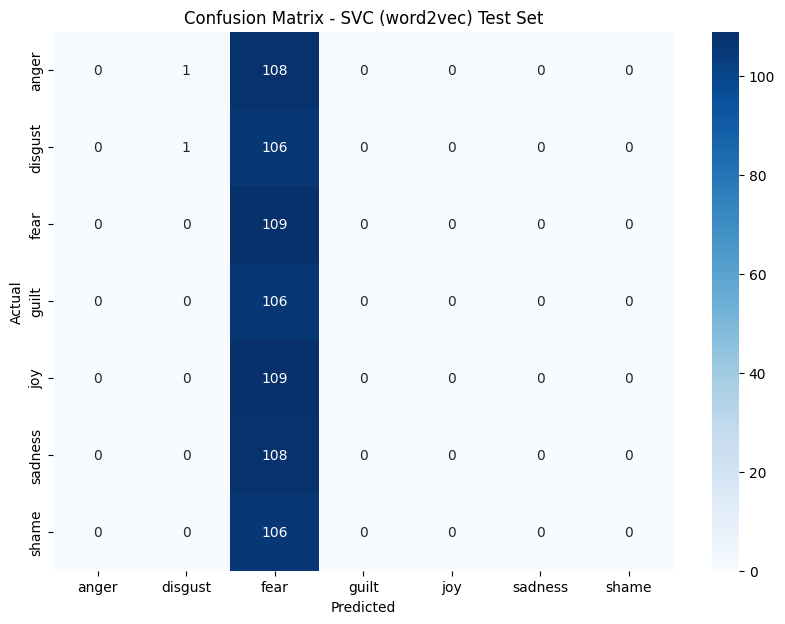

Starting Grid Search for SVC with glove vectorizer...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for glove: {'classifier__C': 30, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best F1 score for glove (from Grid Search): 0.5057522123893804

Classification Report for glove SVC:
              precision    recall  f1-score   support

       anger       0.39      0.41      0.40       109
     disgust       0.50      0.50      0.50       107
        fear       0.67      0.64      0.66       109
       guilt       0.40      0.42      0.41       106
         joy       0.61      0.67      0.64       109
     sadness       0.57      0.51      0.54       108
       shame       0.44      0.42      0.43       106

    accuracy                           0.51       754
   macro avg       0.51      0.51      0.51       754
weighted avg       0.51      0.51      0.51       754



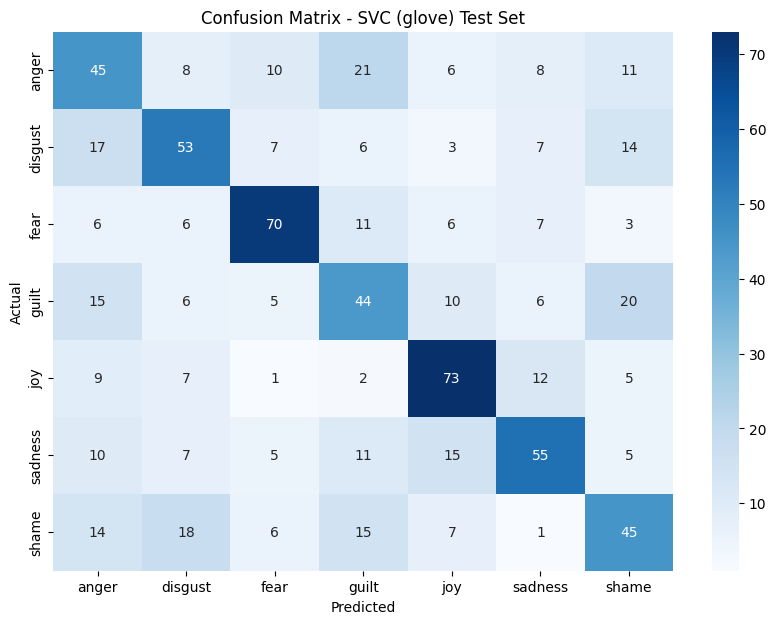

Starting Grid Search for SVC with fasttext vectorizer...
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters for fasttext: {'classifier__C': 30, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best F1 score for fasttext (from Grid Search): 0.2998525073746313

Classification Report for fasttext SVC:
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       109
     disgust       0.15      0.96      0.26       107
        fear       0.17      0.12      0.14       109
       guilt       0.00      0.00      0.00       106
         joy       0.00      0.00      0.00       109
     sadness       0.00      0.00      0.00       108
       shame       0.00      0.00      0.00       106

    accuracy                           0.15       754
   macro avg       0.05      0.15      0.06       754
weighted avg       0.05      0.15      0.06       754



/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

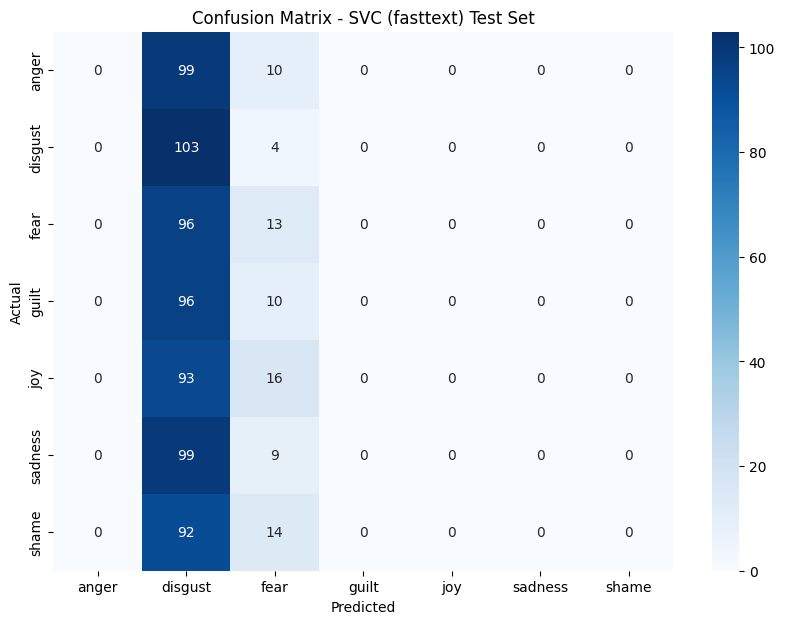

Best Results for Each Vectorizer with SVC:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,tfidf,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
1,Dummy Classifier,word2vec,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
2,Dummy Classifier,glove,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
3,Dummy Classifier,fasttext,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
0,Logistic Regression,tfidf,0.568732,0.144562,0.129332,0.144758,0.129676,"{'classifier__C': 1, 'classifier__class_weight..."
1,Logistic Regression,word2vec,0.379794,0.140584,0.020137,0.142857,0.035298,"{'classifier__C': 0.01, 'classifier__class_wei..."
2,Logistic Regression,glove,0.493068,0.485411,0.481583,0.484682,0.482492,"{'classifier__C': 1, 'classifier__class_weight..."
3,Logistic Regression,fasttext,0.370944,0.144562,0.020652,0.142857,0.036087,"{'classifier__C': 0.01, 'classifier__class_wei..."
0,Decision Tree,tfidf,0.430236,0.144562,0.119846,0.146257,0.086340,"{'classifier__class_weight': None, 'classifier..."
1,Decision Tree,word2vec,0.231121,0.148541,0.065325,0.148202,0.068833,"{'classifier__class_weight': 'balanced', 'clas..."


In [54]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search for SVC
for method in vectorizer_methods:
    print(f"Starting Grid Search for SVC with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", SVC(random_state=42)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__C": [0.01, 0.1, 1, 10, 20, 30],  # Regularization parameter
        "classifier__kernel": ["linear", "rbf", "poly", "sigmoid"],  # Kernel type
        "classifier__gamma": ["scale", "auto"],  # Kernel coefficient
        "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Print the classification report for the current vectorizer
    print(f"\nClassification Report for {method} SVC:")
    print(classification_report(y_test, y_test_pred))

    # Step 7: Generate and plot confusion matrix
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_test_df = pd.DataFrame(
        cm_test, index=grid_search.classes_, columns=grid_search.classes_
    )

    # Plot the confusion matrix for the test set
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_test_df, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix - SVC ({method}) Test Set")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    # Store the best results in the results list
    results.append(
        {
            "Model": "SVC",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df_svc = pd.DataFrame(results)
results_df = pd.concat([results_df, results_df_svc])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer with SVC:")
display(results_df)

### Saving models results

In [55]:
results_df.to_excel(
    "../data/model_results/ml_models_no_preprocessing.xlsx", index=False
)

================================

### Evaluation of Machine Learning Models

Based on the metrics against test set and using **Macro F1-Score** decision criteria, the best Machine Learning to clasificate Text in Emotions is **SVC** with a **Macro F1-Score** of 0.582579

In [61]:
results_df.sort_values(by="Test Macro F1-Score", ascending=False)

,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
2,SVC,glove,0.505752,0.510610,0.511988,0.509854,0.510297,"{'classifier__C': 30, 'classifier__class_weigh..."
2,Logistic Regression,glove,0.490118,0.488064,0.484909,0.487341,0.485231,"{'classifier__C': 1.0892186949935163, 'classif..."
2,Logistic Regression,glove,0.493068,0.485411,0.481583,0.484682,0.482492,"{'classifier__C': 1, 'classifier__class_weight..."
2,Random Forest,glove,0.424336,0.440318,0.438334,0.440062,0.436273,"{'classifier__class_weight': 'balanced', 'clas..."
2,Decision Tree,glove,0.270796,0.277188,0.296779,0.277294,0.281701,"{'classifier__class_weight': 'balanced', 'clas..."
0,Random Forest,tfidf,0.547493,0.149867,0.153838,0.150280,0.141960,"{'classifier__class_weight': 'balanced', 'clas..."
0,SVC,tfidf,0.559587,0.143236,0.131631,0.143609,0.129824,"{'classifier__C': 20, 'classifier__class_weigh..."
0,Logistic Regression,tfidf,0.568732,0.144562,0.129332,0.144758,0.129676,"{'classifier__C': 1, 'classifier__class_weight..."
0,Logistic Regression,tfidf,0.564749,0.140584,0.122921,0.140852,0.126574,"{'classifier__C': 1.0892186949935163, 'classif..."
1,Dummy Classifier,word2vec,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}


In [59]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["glove"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search for SVC
for method in vectorizer_methods:
    print(f"Starting Grid Search for SVC with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", SVC(random_state=42)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__C": [10, 20, 30, 40, 50, 60, 100],  # Regularization parameter
        "classifier__kernel": ["rbf"],  # Kernel type
        "classifier__gamma": ["scale"],  # Kernel coefficient
        "classifier__class_weight": [None, "balanced"],  # Handle class imbalance
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Store the best results in the results list
    results.append(
        {
            "Model": "SVC",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df_svc = pd.DataFrame(results)
# results_df = pd.concat([results_df, results_df_svc])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer with SVC:")
display(results_df_svc)

Starting Grid Search for SVC with glove vectorizer...
Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters for glove: {'classifier__C': 30, 'classifier__class_weight': None, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best F1 score for glove (from Grid Search): 0.5057522123893804
Best Results for Each Vectorizer with SVC:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,SVC,glove,0.505752,0.51061,0.511988,0.509854,0.510297,"{'classifier__C': 30, 'classifier__class_weigh..."


In [60]:
# Step 1: Define the vectorizer methods and initialize the results list
vectorizer_methods = ["tfidf", "word2vec", "glove", "fasttext"]
results = []

# Step 2: Loop through each vectorizer method and perform grid search
for method in vectorizer_methods:
    print(f"Starting Grid Search for Logistic Regression with {method} vectorizer...")

    # Precompute the vectorized data for the current method
    X_train_transformed = vectorize(X_train, method)
    X_test_transformed = vectorize(X_test, method)

    # Step 3: Create the pipeline without the vectorizer step
    pipeline = Pipeline(
        [
            ("classifier", LogisticRegression(max_iter=1000, random_state=140438247)),
        ]
    )

    # Step 4: Define the parameter grid for GridSearchCV
    param_grid = {
        "classifier__C": [1.0892186949935163],
        "classifier__penalty": ["elasticnet"],
        "classifier__class_weight": ["balanced", None],
        "classifier__l1_ratio": [5.526615652657683e-08],
        "classifier__solver": ["sag", "saga"],
    }

    # Step 5: Perform Grid Search using GridSearchCV on precomputed vectors
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="f1_micro",  # F1 score metric
        n_jobs=-1,
        verbose=1,
        refit=True,
    )

    # Fit GridSearchCV on the precomputed vectorized training data
    grid_search.fit(X_train_transformed, y_train)

    # Get the best parameters and scores for the current vectorizer
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(f"Best parameters for {method}:", best_params)
    print(f"Best F1 score for {method} (from Grid Search):", best_score)

    # Step 6: Evaluate the model on the test set with the best parameters
    y_test_pred = grid_search.predict(X_test_transformed)

    # Generate classification report
    test_report = classification_report(
        y_test, y_test_pred, output_dict=True, zero_division=0
    )

    # Store the best results in the results list
    results.append(
        {
            "Model": "Logistic Regression",
            "Vectorizer": method,
            "Best F1 Score (CV)": best_score,
            "Test Accuracy": test_report["accuracy"],
            "Test Macro Precision": test_report["macro avg"]["precision"],
            "Test Macro Recall": test_report["macro avg"]["recall"],
            "Test Macro F1-Score": test_report["macro avg"]["f1-score"],
            "Best Parameters": best_params,
        }
    )

# Step 7: Convert the results list to a DataFrame
results_df_logistic = pd.DataFrame(results)
results_df = pd.concat([results_df, results_df_logistic])

# Display the DataFrame with the best results for each vectorizer
print("Best Results for Each Vectorizer:")
display(results_df)

Starting Grid Search for Logistic Regression with tfidf vectorizer...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dalopeza/TrabajoGradosEAFIT

Best parameters for tfidf: {'classifier__C': 1.0892186949935163, 'classifier__class_weight': None, 'classifier__l1_ratio': 5.526615652657683e-08, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Best F1 score for tfidf (from Grid Search): 0.5647492625368732
Starting Grid Search for Logistic Regression with word2vec vectorizer...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dalopeza/TrabajoGradosEAFIT

Best parameters for word2vec: {'classifier__C': 1.0892186949935163, 'classifier__class_weight': None, 'classifier__l1_ratio': 5.526615652657683e-08, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Best F1 score for word2vec (from Grid Search): 0.2820058997050147
Starting Grid Search for Logistic Regression with glove vectorizer...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dalopeza/TrabajoGradosEAFIT

Best parameters for glove: {'classifier__C': 1.0892186949935163, 'classifier__class_weight': None, 'classifier__l1_ratio': 5.526615652657683e-08, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Best F1 score for glove (from Grid Search): 0.49011799410029494
Starting Grid Search for Logistic Regression with fasttext vectorizer...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/dalopeza/TrabajoGradosEAFIT/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/dalopeza/TrabajoGradosEAFIT

Best parameters for fasttext: {'classifier__C': 1.0892186949935163, 'classifier__class_weight': None, 'classifier__l1_ratio': 5.526615652657683e-08, 'classifier__penalty': 'elasticnet', 'classifier__solver': 'saga'}
Best F1 score for fasttext (from Grid Search): 0.2535398230088496
Best Results for Each Vectorizer:


,Model,Vectorizer,Best F1 Score (CV),Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score,Best Parameters
0,Dummy Classifier,tfidf,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
1,Dummy Classifier,word2vec,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
2,Dummy Classifier,glove,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
3,Dummy Classifier,fasttext,0.140560,0.125995,0.127167,0.125948,0.126359,{'classifier__strategy': 'uniform'}
0,Logistic Regression,tfidf,0.568732,0.144562,0.129332,0.144758,0.129676,"{'classifier__C': 1, 'classifier__class_weight..."
1,Logistic Regression,word2vec,0.379794,0.140584,0.020137,0.142857,0.035298,"{'classifier__C': 0.01, 'classifier__class_wei..."
2,Logistic Regression,glove,0.493068,0.485411,0.481583,0.484682,0.482492,"{'classifier__C': 1, 'classifier__class_weight..."
3,Logistic Regression,fasttext,0.370944,0.144562,0.020652,0.142857,0.036087,"{'classifier__C': 0.01, 'classifier__class_wei..."
0,Decision Tree,tfidf,0.430236,0.144562,0.119846,0.146257,0.086340,"{'classifier__class_weight': None, 'classifier..."
1,Decision Tree,word2vec,0.231121,0.148541,0.065325,0.148202,0.068833,"{'classifier__class_weight': 'balanced', 'clas..."
